# Prediction for individual targets

Targets: H3K4me1, H3K4me3, H3K27ac, H3K27me3, H3K9ac, H3K9me3, H3K36me3

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import h5py
import json
import numpy as np
import os
import sys
from time import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The base directory is one level up
base = '..'

name_3kb = 'roadmap-chip-3kb'
name_12kb = 'roadmap-chip-12kb'
name_120kb = 'roadmap-chip-120kb'

search_name = 'cnn-final'
search_filepath = '{}.json'.format(search_name)

with open(os.path.join(base, 'settings-roadmap-epigenomics-chip-histone-mod-3kb.json'), "r") as f:
    settings_3kb = json.load(f)
with open(os.path.join(base, 'settings-roadmap-epigenomics-chip-histone-mod-12kb.json'), "r") as f:
    settings_12kb = json.load(f)
with open(os.path.join(base, 'settings-roadmap-epigenomics-chip-histone-mod-120kb.json'), "r") as f:
    settings_120kb = json.load(f)

with open(os.path.join(base, search_filepath), "r") as f:
    search = json.load(f)

dataset_eid = 'E116' # GM12878

## Load data and autoencoders

In [2]:
from download import download_roadmap_epigenomics_file, download_file
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True)
Path('models').mkdir(parents=True, exist_ok=True)

download_roadmap_epigenomics_file(dataset_eid, data_type="fc_signal", target="H3K4me1")
download_roadmap_epigenomics_file(dataset_eid, data_type="fc_signal", target="H3K4me3")
download_roadmap_epigenomics_file(dataset_eid, data_type="fc_signal", target="H3K9ac")
download_roadmap_epigenomics_file(dataset_eid, data_type="fc_signal", target="H3K9me3")
download_roadmap_epigenomics_file(dataset_eid, data_type="fc_signal", target="H3K27ac")
download_roadmap_epigenomics_file(dataset_eid, data_type="fc_signal", target="H3K27me3")
download_roadmap_epigenomics_file(dataset_eid, data_type="fc_signal", target="H3K36me3")

download_file(
    "https://zenodo.org/record/2609763/files/chip_w-3000_r-25.h5?download=1",
    "chip_w-3000_r-25.h5",
    dir="models"
)
download_file(
    "https://zenodo.org/record/2609763/files/chip_w-12000_r-100.h5?download=1",
    "chip_w-12000_r-100.h5",
    dir="models"
)
download_file(
    "https://zenodo.org/record/2609763/files/chip_w-120000_r-1000.h5?download=1",
    "chip_w-120000_r-1000.h5",
    dir="models"
)

File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`


## Extract and normalize data

In [3]:
from server import bigwig

t0 = time()
h3k4me1_3kb = bigwig.chunk('data/E116-H3K4me1.fc.signal.bigWig', 3000, 25, 3000 / 3, ['chr22'], verbose=True)
h3k4me3_3kb = bigwig.chunk('data/E116-H3K4me3.fc.signal.bigWig', 3000, 25, 3000 / 3, ['chr22'], verbose=True)
h3k9ac_3kb = bigwig.chunk('data/E116-H3K9ac.fc.signal.bigWig', 3000, 25, 3000 / 3, ['chr22'], verbose=True)
h3k9me3_3kb = bigwig.chunk('data/E116-H3K9me3.fc.signal.bigWig', 3000, 25, 3000 / 3, ['chr22'], verbose=True)
h3k27ac_3kb = bigwig.chunk('data/E116-H3K27ac.fc.signal.bigWig', 3000, 25, 3000 / 3, ['chr22'], verbose=True)
h3k27me3_3kb = bigwig.chunk('data/E116-H3K27me3.fc.signal.bigWig', 3000, 25, 3000 / 3, ['chr22'], verbose=True)
h3k36me3_3kb = bigwig.chunk('data/E116-H3K36me3.fc.signal.bigWig', 3000, 25, 3000 / 3, ['chr22'], verbose=True)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Extracted 51303 windows from chr22 with a max value of 1.0.
Extracted 51303 windows from chr22 with a max value of 1.0.
Extracted 51303 windows from chr22 with a max value of 1.0.
Extracted 51303 windows from chr22 with a max value of 0.9999999999999999.
Extracted 51303 windows from chr22 with a max value of 1.0.
Extracted 51303 windows from chr22 with a max value of 1.0.
Extracted 51303 windows from chr22 with a max value of 1.0.
Done! Took 103.69 seconds (1.7 minutes).


In [4]:
t0 = time()
h3k4me1_12kb = bigwig.chunk('data/E116-H3K4me1.fc.signal.bigWig', 12000, 100, 12000 / 4, ['chr21'], verbose=True)
h3k4me3_12kb = bigwig.chunk('data/E116-H3K4me3.fc.signal.bigWig', 12000, 100, 12000 / 4, ['chr21'], verbose=True)
h3k9ac_12kb = bigwig.chunk('data/E116-H3K9ac.fc.signal.bigWig', 12000, 100, 12000 / 4, ['chr21'], verbose=True)
h3k9me3_12kb = bigwig.chunk('data/E116-H3K9me3.fc.signal.bigWig', 12000, 100, 12000 / 4, ['chr21'], verbose=True)
h3k27ac_12kb = bigwig.chunk('data/E116-H3K27ac.fc.signal.bigWig', 12000, 100, 12000 / 4, ['chr21'], verbose=True)
h3k27me3_12kb = bigwig.chunk('data/E116-H3K27me3.fc.signal.bigWig', 12000, 100, 12000 / 4, ['chr21'], verbose=True)
h3k36me3_12kb = bigwig.chunk('data/E116-H3K36me3.fc.signal.bigWig', 12000, 100, 12000 / 4, ['chr21'], verbose=True)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Extracted 16041 windows from chr21 with a max value of 1.0.
Extracted 16041 windows from chr21 with a max value of 1.0.
Extracted 16041 windows from chr21 with a max value of 1.0.
Extracted 16041 windows from chr21 with a max value of 0.9999999999999999.
Extracted 16041 windows from chr21 with a max value of 1.0.
Extracted 16041 windows from chr21 with a max value of 1.0.
Extracted 16041 windows from chr21 with a max value of 1.0.
Done! Took 36.10 seconds (0.6 minutes).


In [5]:
t0 = time()
h3k4me1_120kb = bigwig.chunk('data/E116-H3K4me1.fc.signal.bigWig', 120000, 1000, 120000 / 6, ['chr1'], verbose=True)
h3k4me3_120kb = bigwig.chunk('data/E116-H3K4me3.fc.signal.bigWig', 120000, 1000, 120000 / 6, ['chr1'], verbose=True)
h3k9ac_120kb = bigwig.chunk('data/E116-H3K9ac.fc.signal.bigWig', 120000, 1000, 120000 / 6, ['chr1'], verbose=True)
h3k9me3_120kb = bigwig.chunk('data/E116-H3K9me3.fc.signal.bigWig', 120000, 1000, 120000 / 6, ['chr1'], verbose=True)
h3k27ac_120kb = bigwig.chunk('data/E116-H3K27ac.fc.signal.bigWig', 120000, 1000, 120000 / 6, ['chr1'], verbose=True)
h3k27me3_120kb = bigwig.chunk('data/E116-H3K27me3.fc.signal.bigWig', 120000, 1000, 120000 / 6, ['chr1'], verbose=True)
h3k36me3_120kb = bigwig.chunk('data/E116-H3K36me3.fc.signal.bigWig', 120000, 1000, 120000 / 6, ['chr1'], verbose=True)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Extracted 12458 windows from chr1 with a max value of 1.0.
Extracted 12458 windows from chr1 with a max value of 1.0.
Extracted 12458 windows from chr1 with a max value of 0.9999999999999999.
Extracted 12458 windows from chr1 with a max value of 1.0.
Extracted 12458 windows from chr1 with a max value of 1.0.
Extracted 12458 windows from chr1 with a max value of 1.0.
Extracted 12458 windows from chr1 with a max value of 0.9999999999999999.
Done! Took 74.04 seconds (1.2 minutes).


In [7]:
"""Cache data to avoid having to re-extract in case we need to restart the notebook"""

with h5py.File('data/chunked-windows.h5', 'w') as f:
    f.create_dataset('h3k4me1_3kb', data=h3k4me1_3kb)
    f.create_dataset('h3k4me3_3kb', data=h3k4me3_3kb)
    f.create_dataset('h3k9ac_3kb', data=h3k9ac_3kb)
    f.create_dataset('h3k9me3_3kb', data=h3k9me3_3kb)
    f.create_dataset('h3k27ac_3kb', data=h3k27ac_3kb)
    f.create_dataset('h3k27me3_3kb', data=h3k27me3_3kb)
    f.create_dataset('h3k36me3_3kb', data=h3k36me3_3kb)
    f.create_dataset('h3k4me1_12kb', data=h3k4me1_12kb)
    f.create_dataset('h3k4me3_12kb', data=h3k4me3_12kb)
    f.create_dataset('h3k9ac_12kb', data=h3k9ac_12kb)
    f.create_dataset('h3k9me3_12kb', data=h3k9me3_12kb)
    f.create_dataset('h3k27ac_12kb', data=h3k27ac_12kb)
    f.create_dataset('h3k27me3_12kb', data=h3k27me3_12kb)
    f.create_dataset('h3k36me3_12kb', data=h3k36me3_12kb)
    f.create_dataset('h3k4me1_120kb', data=h3k4me1_120kb)
    f.create_dataset('h3k4me3_120kb', data=h3k4me3_120kb)
    f.create_dataset('h3k9ac_120kb', data=h3k9ac_120kb)
    f.create_dataset('h3k9me3_120kb', data=h3k9me3_120kb)
    f.create_dataset('h3k27ac_120kb', data=h3k27ac_120kb)
    f.create_dataset('h3k27me3_120kb', data=h3k27me3_120kb)
    f.create_dataset('h3k36me3_120kb', data=h3k36me3_120kb)

/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


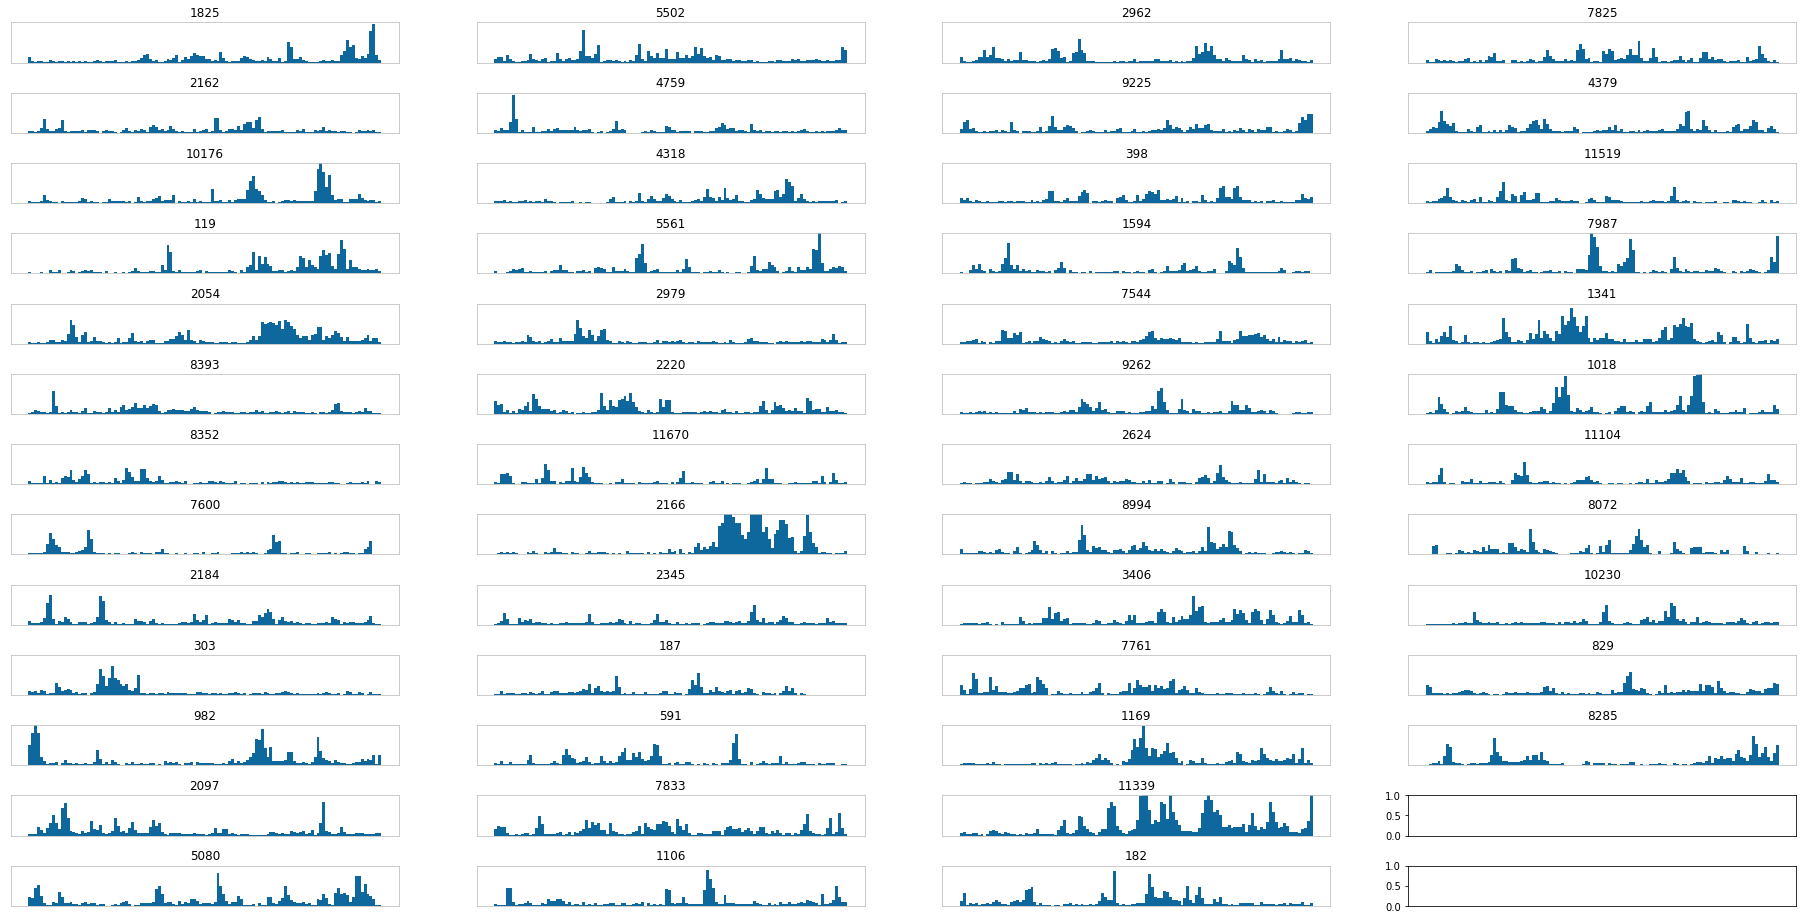

In [89]:
from ae.utils import plot_windows_from_data

plot_windows_from_data(
    h3k4me1_120kb,
    min_signal=8,
    num=50,
    window_ids=None,
    predictions=None,
)

In [11]:
window_ids = {
  '3kb': {
    'h3k4me1': [42310, 22182, 39363, 37669, 43386, 35703],
    'h3k4me3': [36876, 35652, 30782, 29975, 40502, 23477],
    'h3k9ac': [37558, 50979, 35795, 50911, 50963, 46430],
    'h3k9me3': [31387, 48743, 33758, 43586, 47834, 22215],
    'h3k27ac': [47008, 45644, 46730, 48493, 42839, 50246],
    'h3k27me3': [22725, 44964, 39170, 36492, 23410, 23367],
    'h3k36me3': [31409, 38042, 32194, 43021, 18209, 46704]
  },
  '12kb': {
    'h3k4me1': [15928, 15220, 12482, 5364, 14781, 5473],
    'h3k4me3': [12508, 6395, 14924, 12858, 10203, 10223],
    'h3k9ac': [12858, 10129, 5303, 5476, 15190, 12562],
    'h3k9me3': [3616, 14236, 3215, 11409, 15969, 15301],
    'h3k27ac': [14648, 11971, 12013, 12002, 12020, 15448],
    'h3k27me3': [12804, 13408, 14292, 15023, 16014, 13153],
    'h3k36me3': [15215, 15174, 15903, 12958, 14854, 9027]
  },
  '120kb': {
    'h3k4me1': [2168, 11340, 7600, 300, 2056, 3406],
    'h3k4me3': [1358, 11734, 11683, 11341, 7740, 8054],
    'h3k9ac': [11733, 10568, 1329, 1261, 11752, 2260],
    'h3k9me3': [5724, 1748, 2358, 12325, 7344, 7857],
    'h3k27ac': [481, 1558, 5091, 1632, 9190, 11737],
    'h3k27me3': [7995, 858, 6060, 2382, 11329, 1645],
    'h3k36me3': [3574, 584, 10342, 5032, 5479, 2778]
  }
}

In [ ]:
plot_windows_from_data(
    h3k4me1_120kb,
    window_ids=window_ids['120kb']['h3k4me1'],
    predictions=None,
)

In [15]:
with h5py.File('data/chunked-windows.h5', 'r') as f:
    data = {
        '3kb': {
            'h3k4me1': f['h3k4me1_3kb'][:],
            'h3k4me3': f['h3k4me3_3kb'][:],
            'h3k9ac': f['h3k9ac_3kb'][:],
            'h3k9me3': f['h3k9me3_3kb'][:],
            'h3k27ac': f['h3k27ac_3kb'][:],
            'h3k27me3': f['h3k27me3_3kb'][:],
            'h3k36me3': f['h3k36me3_3kb'][:]
        },
        '12kb': {
            'h3k4me1': f['h3k4me1_12kb'][:],
            'h3k4me3': f['h3k4me3_12kb'][:],
            'h3k9ac': f['h3k9ac_12kb'][:],
            'h3k9me3': f['h3k9me3_12kb'][:],
            'h3k27ac': f['h3k27ac_12kb'][:],
            'h3k27me3': f['h3k27me3_12kb'][:],
            'h3k36me3': f['h3k36me3_12kb'][:]
        },
        '120kb': {
            'h3k4me1': f['h3k4me1_120kb'][:],
            'h3k4me3': f['h3k4me3_120kb'][:],
            'h3k9ac': f['h3k9ac_120kb'][:],
            'h3k9me3': f['h3k9me3_120kb'][:],
            'h3k27ac': f['h3k27ac_120kb'][:],
            'h3k27me3': f['h3k27me3_120kb'][:],
            'h3k36me3': f['h3k36me3_120kb'][:]
        }
    }
    
preds = {
    '3kb': {
        'h3k4me1': None,
        'h3k4me3': None,
        'h3k9ac': None,
        'h3k9me3': None,
        'h3k27ac': None,
        'h3k27me3': None,
        'h3k36me3': None,
    },
    '12kb': {
        'h3k4me1': None,
        'h3k4me3': None,
        'h3k9ac': None,
        'h3k9me3': None,
        'h3k27ac': None,
        'h3k27me3': None,
        'h3k36me3': None,
    },
    '120kb': {
        'h3k4me1': None,
        'h3k4me3': None,
        'h3k9ac': None,
        'h3k9me3': None,
        'h3k27ac': None,
        'h3k27me3': None,
        'h3k36me3': None,
    }
}

In [9]:
"""Load 3 kb autoencoder"""

from ae.utils import predict
from keras.models import load_model

ae_3kb = load_model('models/chip_w-3000_r-25.h5')

In [29]:
targets_3kb = np.zeros((7 * 6, 120))
for i, target in enumerate(window_ids['3kb']):
    for j, win_id in enumerate(window_ids['3kb'][target]):
        targets_3kb[(i * 6) + j] = data['3kb'][target][win_id]

preds_3kb, _, _ = predict(None, None, targets_3kb.reshape(targets_3kb.shape[0], targets_3kb.shape[1], 1), autoencoder=ae_3kb)


for i, target in enumerate(window_ids['3kb']):
    preds['3kb'][target] = preds_3kb[(i * 6): ((i + 1) * 6)]

/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrec

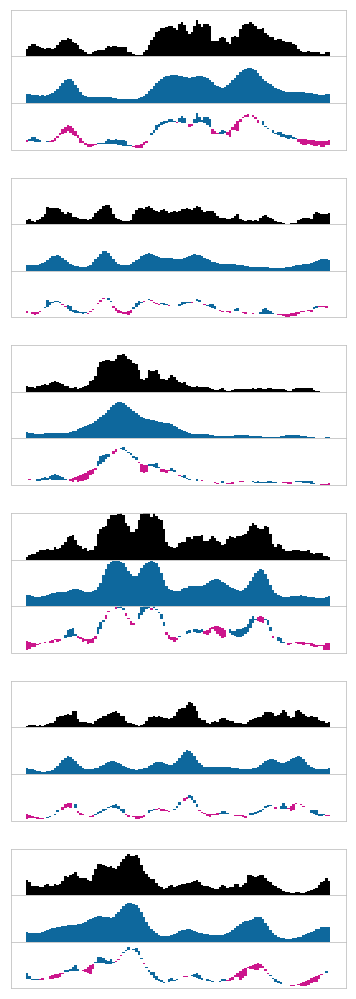

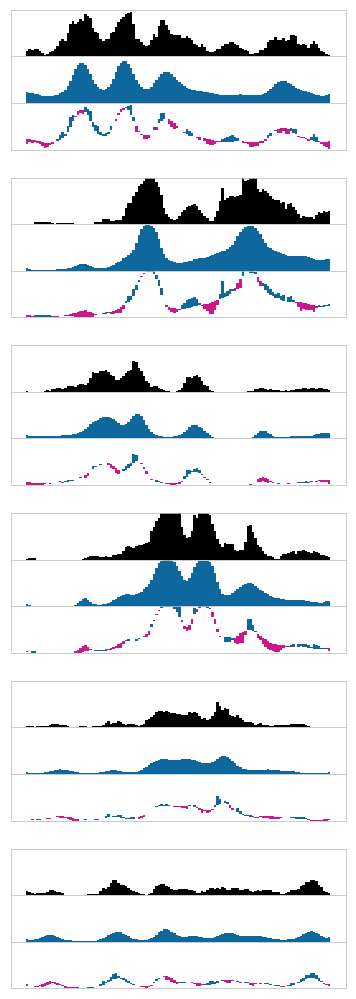

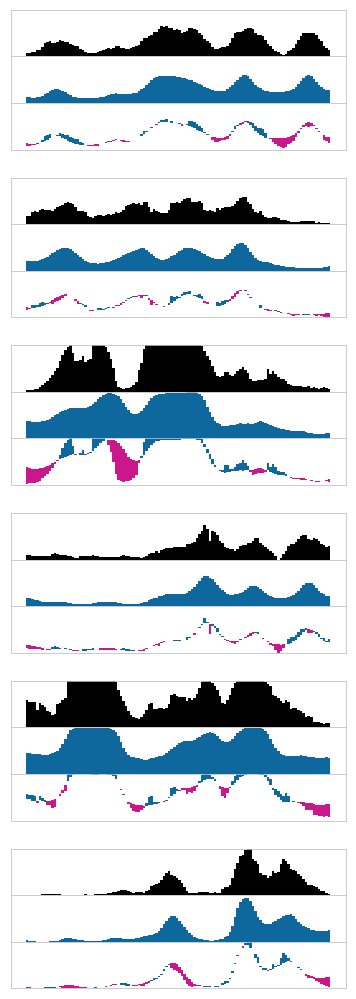

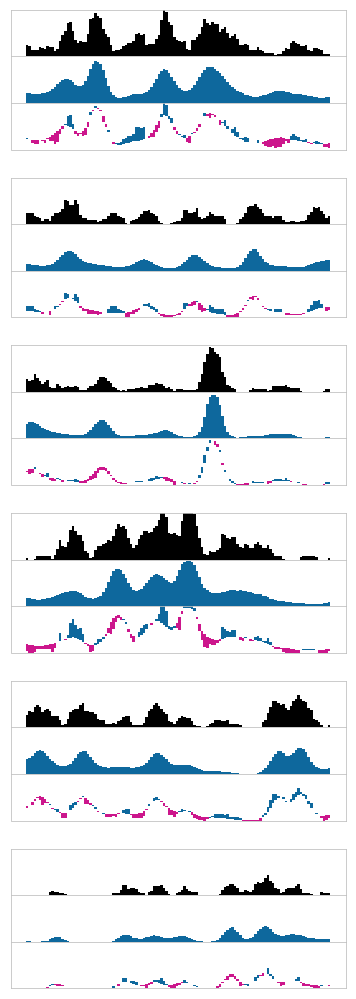

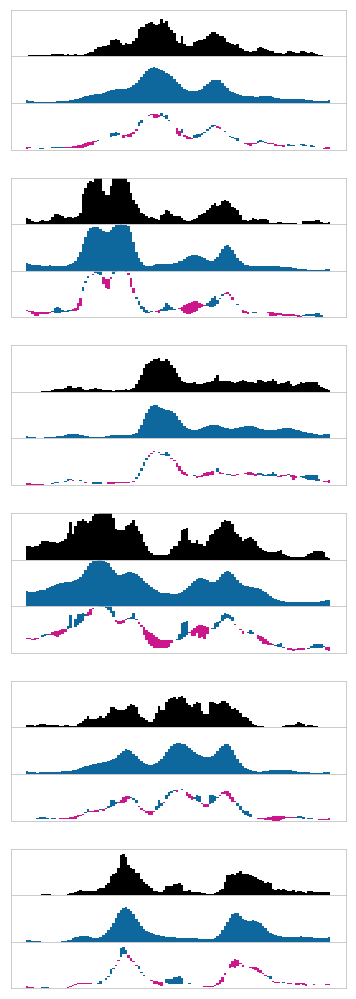

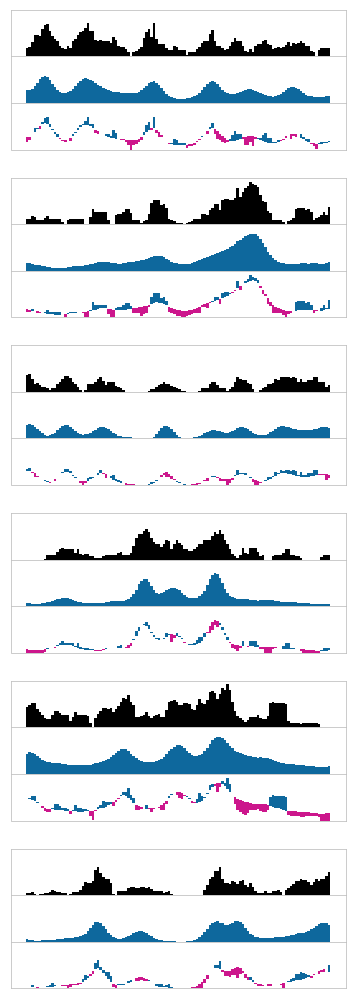

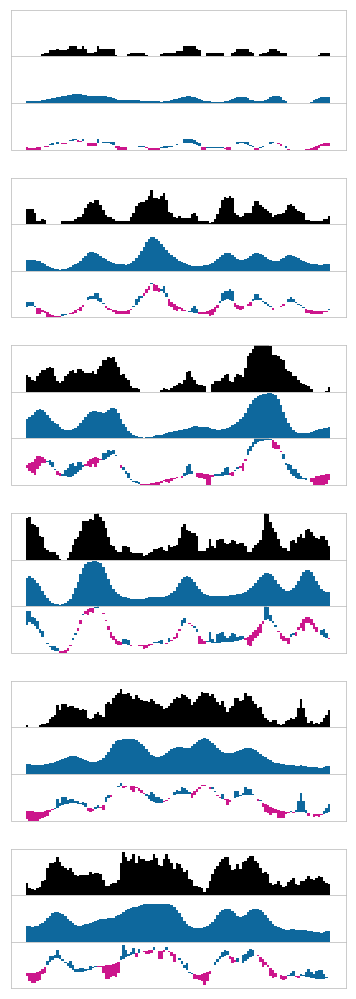

In [34]:
from ae.utils import plot_windows_from_data

for target in window_ids['3kb']:
    plot_windows_from_data(
        data['3kb'][target][window_ids['3kb'][target]],
        window_ids=list(range(6)),
        predictions=preds['3kb'][target].squeeze(axis=2),
        plot_pred_separately=True,
        diff=True,
        no_title=True,
        save_as='images/reconstruction-chip-{}-3kb.png'.format(target)
    )

In [35]:
"""Load 12 kb autoencoder"""

from ae.utils import predict
from keras.models import load_model

ae_12kb = load_model('models/chip_w-12000_r-100.h5')

In [36]:
targets_12kb = np.zeros((7 * 6, 120))
for i, target in enumerate(window_ids['12kb']):
    for j, win_id in enumerate(window_ids['12kb'][target]):
        targets_12kb[(i * 6) + j] = data['12kb'][target][win_id]

preds_12kb, _, _ = predict(None, None, targets_12kb.reshape(targets_12kb.shape[0], targets_12kb.shape[1], 1), autoencoder=ae_12kb)


for i, target in enumerate(window_ids['12kb']):
    preds['12kb'][target] = preds_12kb[(i * 6): ((i + 1) * 6)]

/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrec

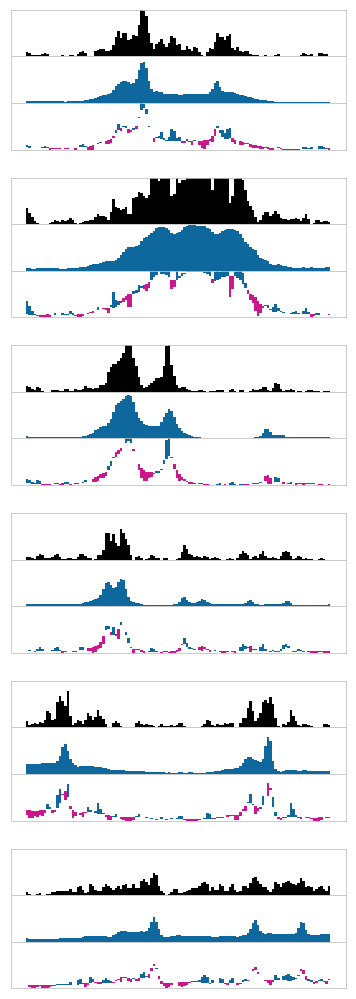

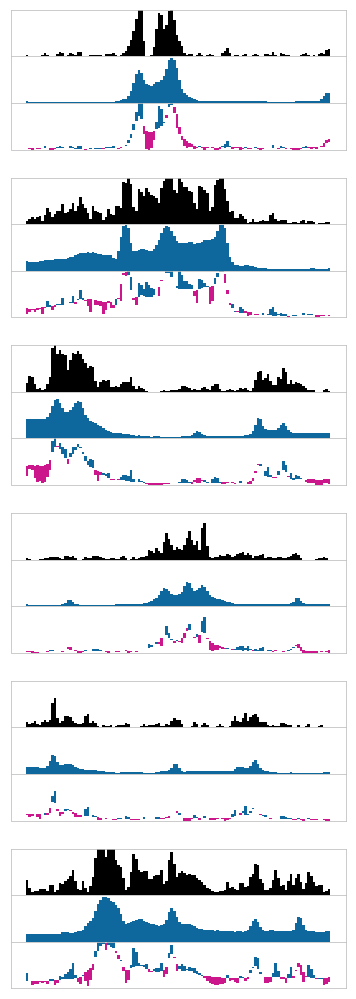

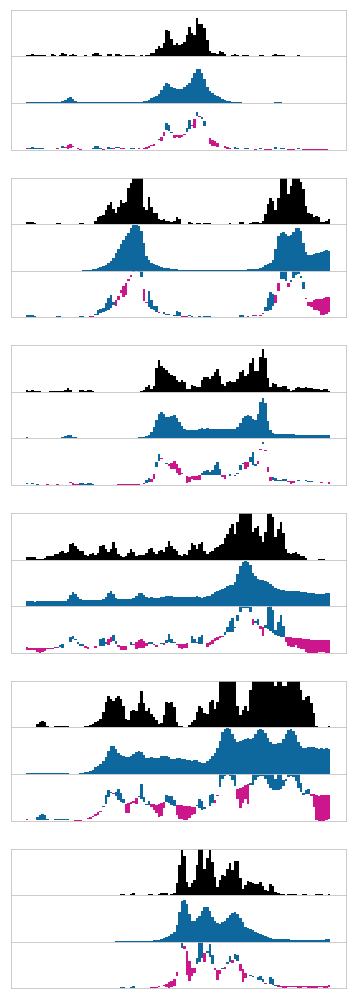

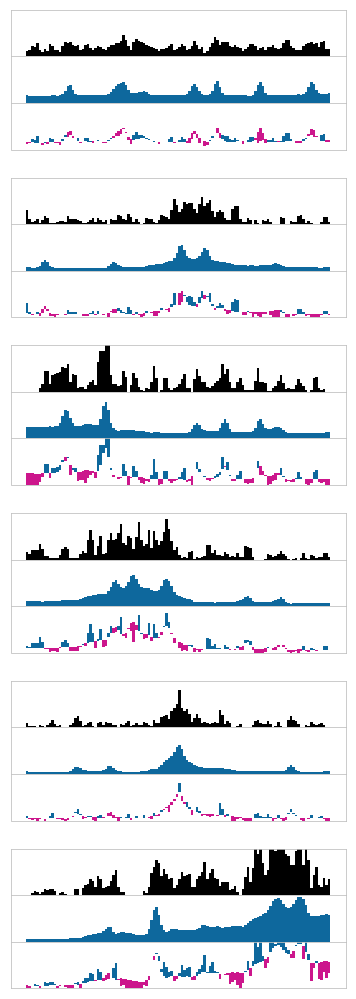

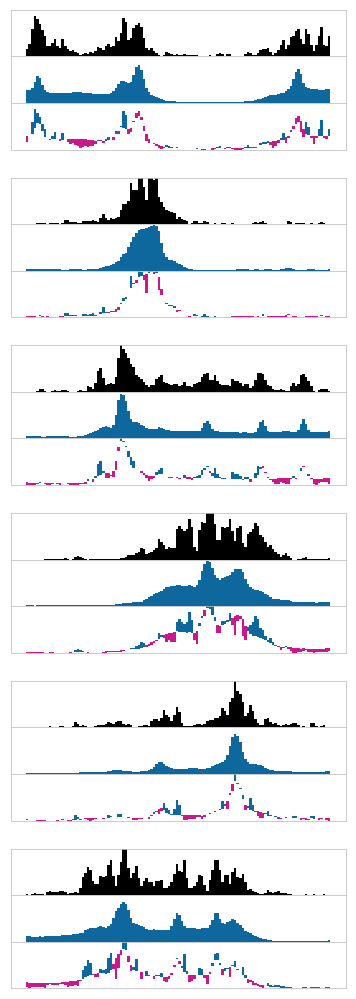

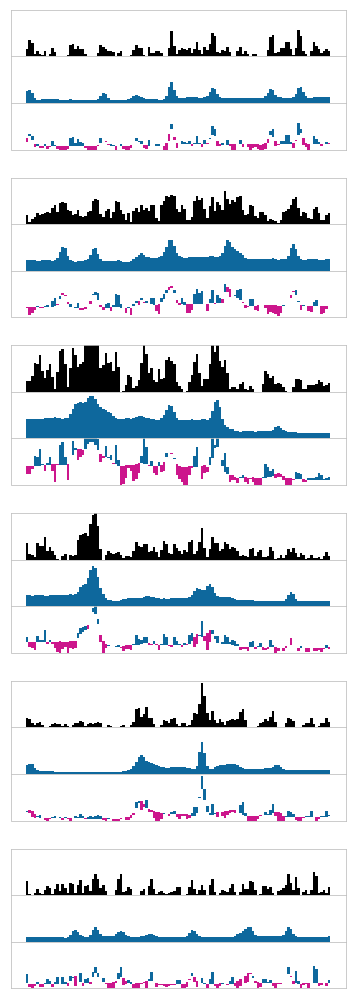

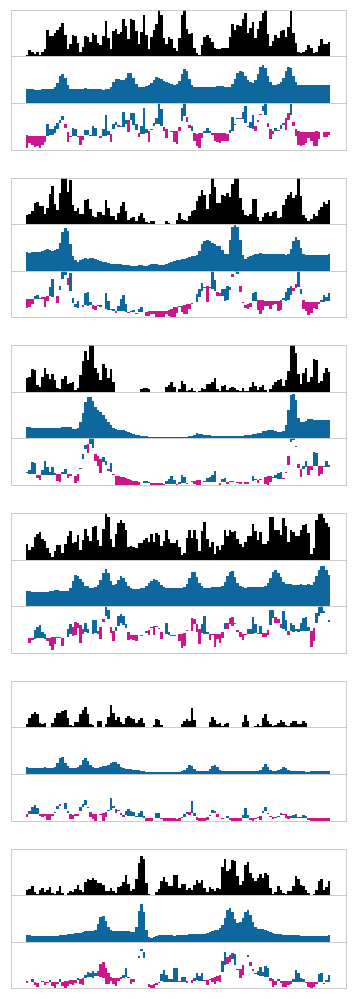

In [38]:
from ae.utils import plot_windows_from_data

for target in window_ids['12kb']:
    plot_windows_from_data(
        data['12kb'][target][window_ids['12kb'][target]],
        window_ids=list(range(6)),
        predictions=preds['12kb'][target].squeeze(axis=2),
        plot_pred_separately=True,
        diff=True,
        no_title=True,
        save_as='images/reconstruction-chip-{}-12kb.png'.format(target)
    )

In [39]:
"""Load 120 kb autoencoder"""

from ae.utils import predict
from keras.models import load_model

ae_120kb = load_model('models/chip_w-120000_r-1000.h5')

In [40]:
targets_120kb = np.zeros((7 * 6, 120))
for i, target in enumerate(window_ids['120kb']):
    for j, win_id in enumerate(window_ids['120kb'][target]):
        targets_120kb[(i * 6) + j] = data['120kb'][target][win_id]

preds_120kb, _, _ = predict(None, None, targets_120kb.reshape(targets_120kb.shape[0], targets_120kb.shape[1], 1), autoencoder=ae_120kb)


for i, target in enumerate(window_ids['120kb']):
    preds['120kb'][target] = preds_120kb[(i * 6): ((i + 1) * 6)]

/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrec

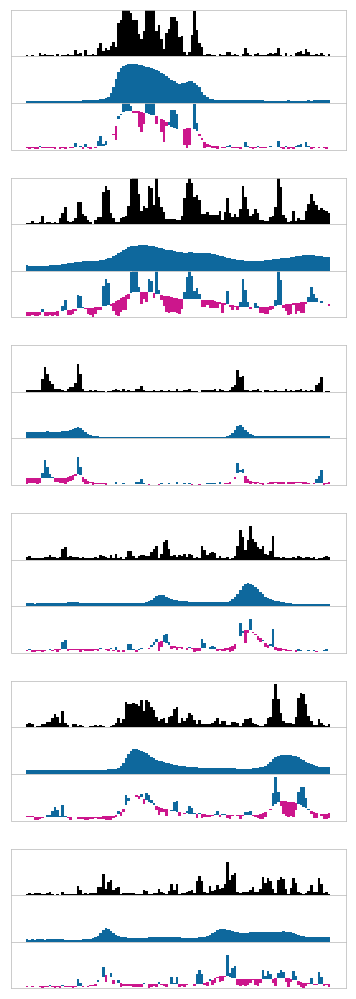

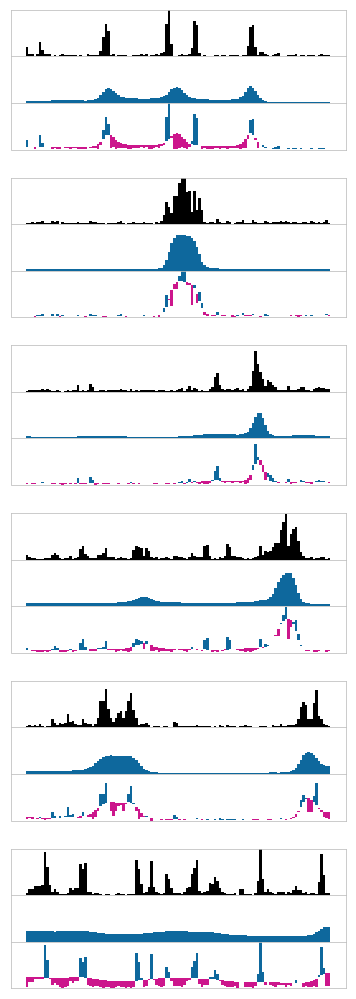

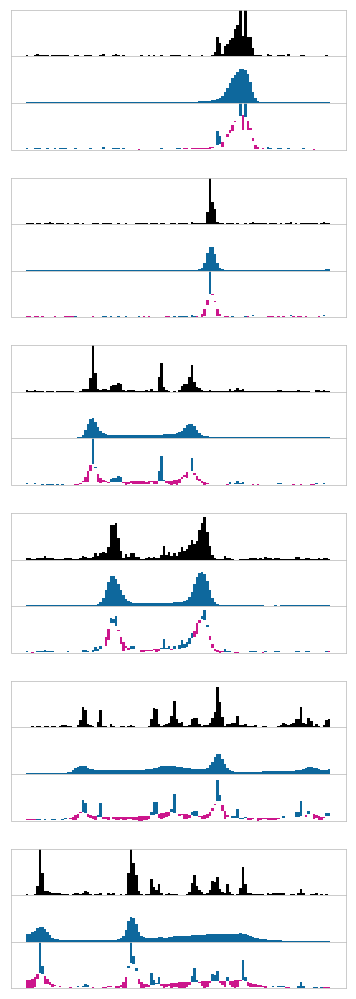

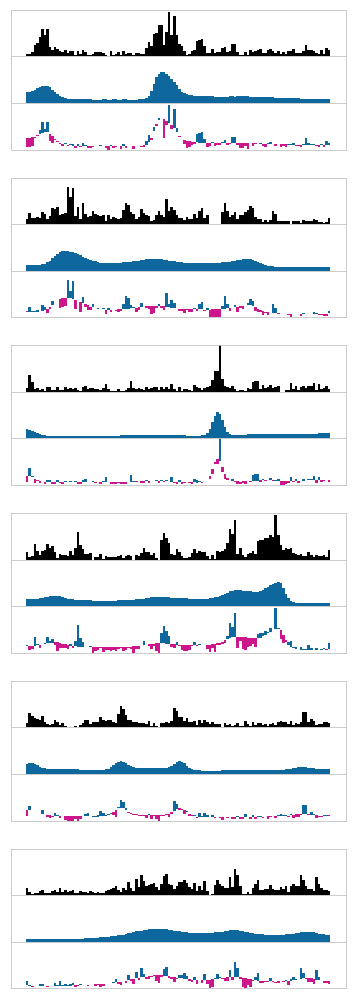

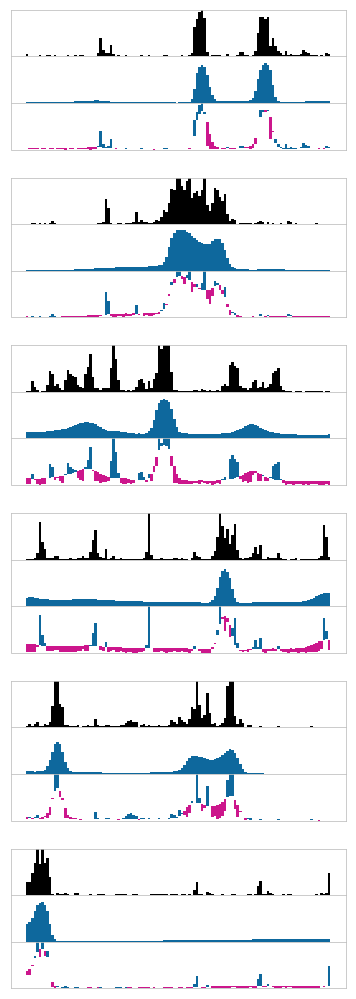

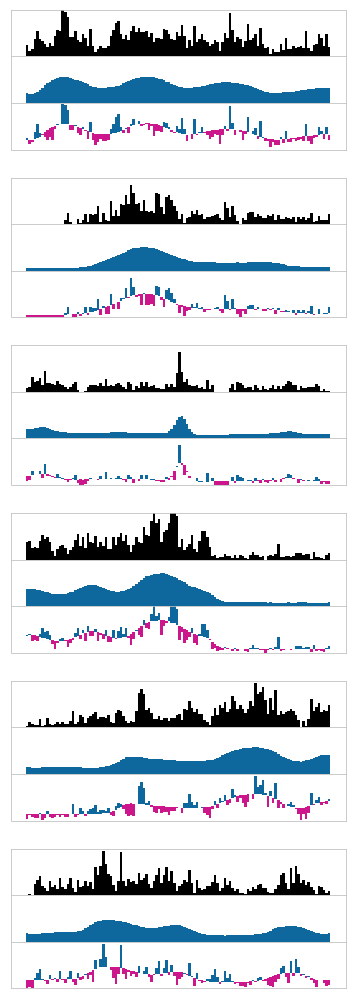

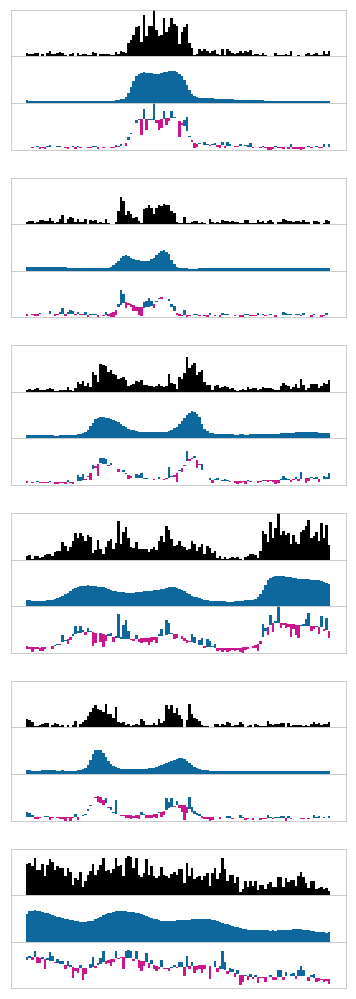

In [41]:
from ae.utils import plot_windows_from_data

for target in window_ids['120kb']:
    plot_windows_from_data(
        data['120kb'][target][window_ids['120kb'][target]],
        window_ids=list(range(6)),
        predictions=preds['120kb'][target].squeeze(axis=2),
        plot_pred_separately=True,
        diff=True,
        no_title=True,
        save_as='images/reconstruction-chip-{}-120kb.png'.format(target)
    )